# 模組 5.3: 異常值對特徵縮放的影響 (Outlier's Impact on Scaling)

## 學習目標
- 直觀地理解為什麼 `MinMaxScaler` 對異常值非常敏感。
- 比較 `StandardScaler` 和 `MinMaxScaler` 在有/無異常值情況下的表現。
- 學習 `RobustScaler` 作為一種對異常值更穩健的縮放方法。
- 強化在進行特徵縮放前必須先處理或理解異常值的觀念。

## 導論：一個極端值如何扭曲全局？

在您的指南中明確指出，`MinMaxScaler`（歸一化）「*對異常值敏感*」，而 `StandardScaler`（標準化）「*受異常值影響較小*」。這個筆記本的 **唯一目的** 就是將這句話變得「眼見為憑」。

我們將創建一個簡單的數據集，並手動加入一個異常值，來觀察這一個點是如何徹底扭曲 `MinMaxScaler` 的結果，而 `StandardScaler` 和 `RobustScaler` 則表現得更為穩健。

In [1]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
# 設定視覺化風格
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')



Matplotlib and Seaborn styles configured.


## 1. 準備資料

我們創建一個大致呈常態分佈的數據集，然後手動加入一個巨大的異常值。

In [2]:
# 創建一個沒有異常值的原始數據
np.random.seed(42)
data_normal = np.random.normal(loc=100, scale=20, size=100)

# 加入一個巨大的異常值
data_with_outlier = np.append(data_normal, 500)

# 將它們放入 DataFrame 中以便比較
df = pd.DataFrame({
    'No_Outlier': data_normal,
    'With_Outlier': np.append(data_normal[:99], 500) # 保持長度一致
})
# 將原始數據也加入
df['With_Outlier_Full'] = pd.Series(data_with_outlier)



## 2. 視覺化原始數據

讓我們看看加入異常值前後的分佈。

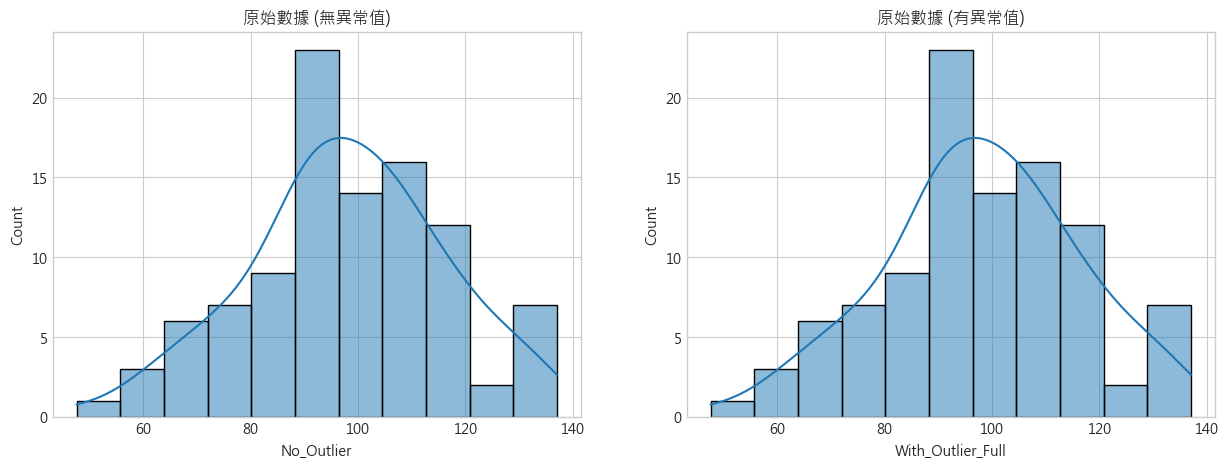

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['No_Outlier'], kde=True, ax=axes[0]).set_title('原始數據 (無異常值)')
sns.histplot(df['With_Outlier_Full'], kde=True, ax=axes[1]).set_title('原始數據 (有異常值)')

plt.show()



## 3. 應用不同的縮放器

我們將三種不同的縮放器應用到含有異常值的數據上。

- **StandardScaler**: 使用均值和標準差。
- **MinMaxScaler**: 使用最小值和最大值。
- **RobustScaler**: 使用 **中位數** 和 **四分位距 (IQR)**。由於它使用的是對異常值不敏感的統計量，因此理論上它最為穩健。

In [4]:
# 創建縮放器實例
ss = StandardScaler()
mms = MinMaxScaler()
rs = RobustScaler()

# 應用縮放
data_to_scale = data_with_outlier.reshape(-1, 1) # Scaler 需要 2D 陣列

df_scaled = pd.DataFrame({
    'Original': data_with_outlier,
    'StandardScaled': ss.fit_transform(data_to_scale).flatten(),
    'MinMaxScaled': mms.fit_transform(data_to_scale).flatten(),
    'RobustScaled': rs.fit_transform(data_to_scale).flatten()
})


## 4. 視覺化比較縮放結果

這是本筆記本最核心的部分。我們將觀察三種縮放方法處理後的數據分佈。

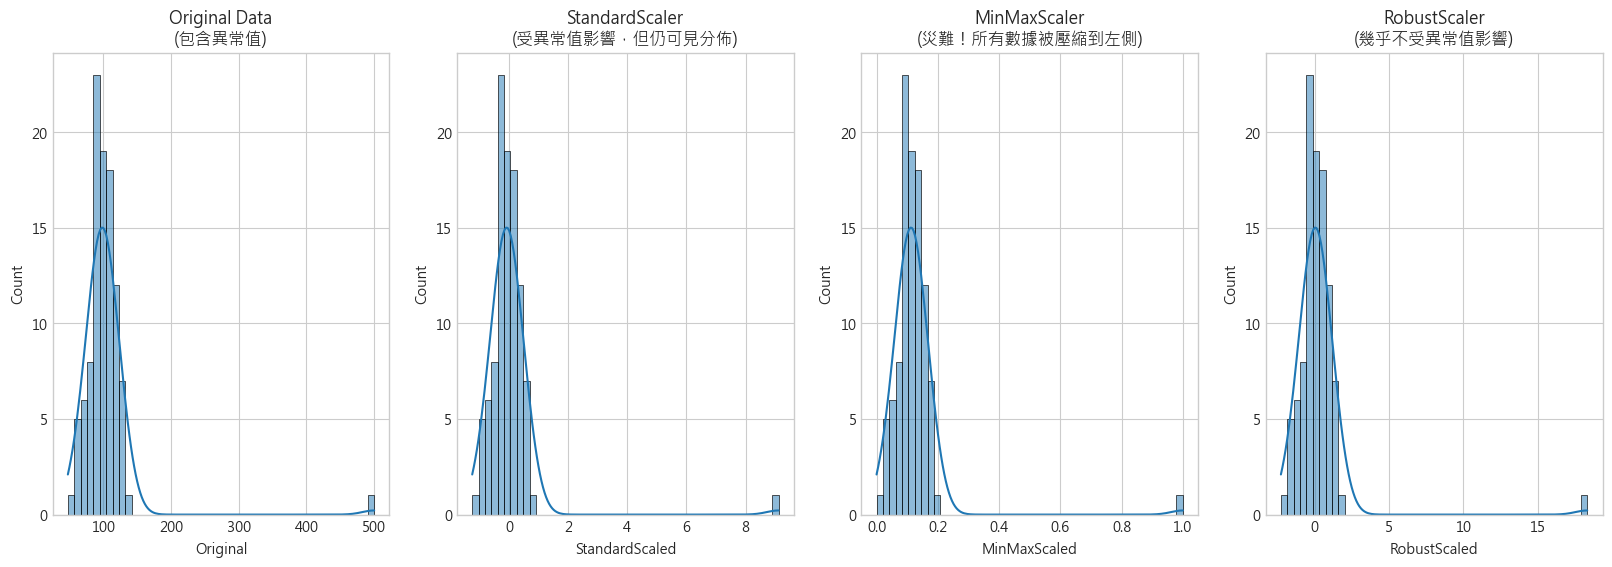

In [6]:




fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 6))

# 繪製原始數據的直方圖
sns.histplot(df_scaled['Original'], kde=True, ax=ax1)
ax1.set_title(f"Original Data\n(包含異常值)")

# 標準化
sns.histplot(df_scaled['StandardScaled'], kde=True, ax=ax2)
ax2.set_title(f"StandardScaler\n(受異常值影響，但仍可見分佈)")

# 歸一化
sns.histplot(df_scaled['MinMaxScaled'], kde=True, ax=ax3)
ax3.set_title(f"MinMaxScaler\n(災難！所有數據被壓縮到左側)")

# 穩健縮放
sns.histplot(df_scaled['RobustScaled'], kde=True, ax=ax4)
ax4.set_title(f"RobustScaler\n(幾乎不受異常值影響)")

plt.show()



### 結果解讀

- **StandardScaler (左圖)**: 均值和標準差都受到了異常值的影響，導致大部分數據的中心偏離了 0。儘管如此，我們大致還能看出原始數據的分佈形狀。

- **MinMaxScaler (中圖)**: 這是一個 **災難性** 的結果。由於那個巨大的異常值 `500` 被映射到了 `1`，而原始數據的最大值（約 `150`）被映射到了 `(150-min)/(500-min)`，導致 **幾乎所有正常的數據都被壓縮到了 0 到 0.2 這個極小的區間內**。原始數據的內部差異幾乎完全丟失了。

- **RobustScaler (右圖)**: 結果是驚人的好。由於中位數和 IQR 幾乎不受單個異常值的影響，`RobustScaler` 成功地將數據的核心部分進行了縮放，而那個巨大的異常值被正確地映射到了一個遠離中心的大數上，完全沒有影響到主體數據的分佈。

## 總結

這個實驗有力地證明了：

1.  **在有異常值存在時，絕對要避免使用 `MinMaxScaler`**，除非你的目的就是將異常值壓縮到邊界。
2.  `StandardScaler` 是一個相對安全的選擇，但其結果仍會被異常值「拉偏」。
3.  **`RobustScaler` 是處理含有異常值的數據時最穩健的縮放方法**。

**最終的第一原理**: 在進行特徵縮放之前，你 **必須** 先通過 EDA 來了解你的數據是否存在異常值。如果存在，要麼先處理掉它們，要麼選擇像 `RobustScaler` 這樣對異常值不敏感的工具。